In [46]:
# 1.04.2024
# обновлена схема, построены графики для пилотного сигнала

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
%matplotlib widget

На картинке изображена структурная схема модели, которую планируется реализовать.

- Желтым цветом отмечены блоки, функции для которых на данный момент прописаны.

- Синим цветом отмечены блоки, над которыми либо ведется работа, либо они просто пропущены (тк не написан другой блок, без которого этот не может обойтись), но будут в финальной модели.

- Красным цветом отмечены блоки, которые делать не планируется.

![Структурная схема модели](model_structure.png)

Каждый блок этой диаграммы (или набор блоков) реализован как отдельная функция, преобразующая входной в нее массив.

Основной управляющий файл `ofdm_modem.m` сохраняет данные с выхода каждого блока в txt файл. Поэтому можно смотреть как преобразуется сигнал от блока к блоку.

На вход он принимает следующие параметры - порядок модулятора `M` (2,4,8,16,64...); длину фрейма `fr_len` (степень двойки); соотношение сигнал/шум на приемнике в децибелах `SNR_dB`; длину циклического префикса `cp_length`.

In [47]:
M = 16; # e.g. 2, 4, 8 -> PSK; 16, 64... -> QAM
fr_len = 64; # the length of OFDM frame
SNR_dB = 20; # [dBW] the signal power is normalized to 1 W
cp_length = fr_len/2; # the size of cyclic prefix

### Созвездие модулятора и отсчеты принятого сигнала в частотной области

In [48]:
info_frame = pd.read_csv('model_version01\\info_frame.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
info_frame_fd = pd.read_csv('model_version01\\info_frame_fd.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
pilots_frame_fd = pd.read_csv('model_version01\\pilots_frame_fd.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
metrics = pd.read_csv('model_version01\\metrics.txt', sep=',', index_col=False, header=None, names=['value'])

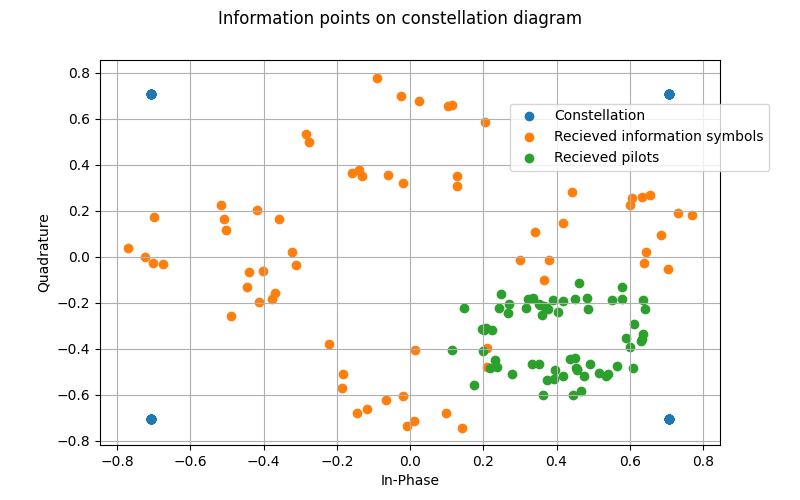

In [70]:
fig1 = plt.figure(figsize=(8,5))
ax_1 = fig1.add_subplot(111)
ax_1.scatter(info_frame['Re'], info_frame['Im'], label='Constellation')
ax_1.scatter(info_frame_fd['Re'], info_frame_fd['Im'], label='Recieved information symbols')
ax_1.scatter(pilots_frame_fd['Re'], pilots_frame_fd['Im'], label='Recieved pilots')
ax_1.set_ylabel("Quadrature")
ax_1.set_xlabel(r"In-Phase")
ax_1.legend(bbox_to_anchor=(0.65, 0.8))
ax_1.grid()
#ax_1.set_title('Real part')
fig1.suptitle('Information points on constellation diagram')
plt.show()

### Созвездие модулятора и эквализованные точки

In [71]:
info_frame_equalized = pd.read_csv('model_version01\\info_frame_equalized.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])

In [ ]:
fig5 = plt.figure(figsize=(8,5))
ax_1 = fig5.add_subplot(111)
ax_1.scatter(info_frame['Re'], info_frame['Im'], label='Constellation')
ax_1.scatter(info_frame_equalized['Re'], info_frame_equalized['Im'], label='Equalized points')
ax_1.set_ylabel("Quadrature")
ax_1.set_xlabel(r"In-Phase")
ax_1.legend(bbox_to_anchor=(0.65, 0.8))
ax_1.grid()
#ax_1.set_title('Real part')
fig5.suptitle('Information points on constellation diagram')
plt.show()

### Фрейм во временной области и добавление циклического префикса

In [50]:
info_frame_td = pd.read_csv('model_version01\\info_frame_td.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])

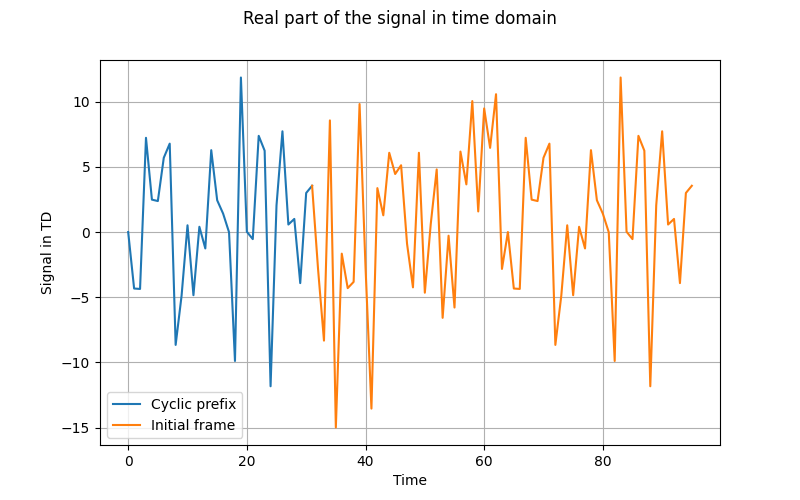

In [51]:
cp_size = int(len(info_frame_td['Re'])/3)

fig2 = plt.figure(figsize=(8,5))
ax_1 = fig2.add_subplot(111)
ax_1.plot(info_frame_td.index[:cp_size], info_frame_td['Re'][:cp_size], label='Cyclic prefix')
ax_1.plot(info_frame_td.index[cp_size-1:], info_frame_td['Re'][cp_size-1:], label='Initial frame')
ax_1.set_ylabel("Signal in TD")
ax_1.set_xlabel(r"Time")
ax_1.legend()
ax_1.grid()
#ax_1.set_title('Real part')
fig2.suptitle('Real part of the signal in time domain')
plt.show()

### Спектр выходного сигнала

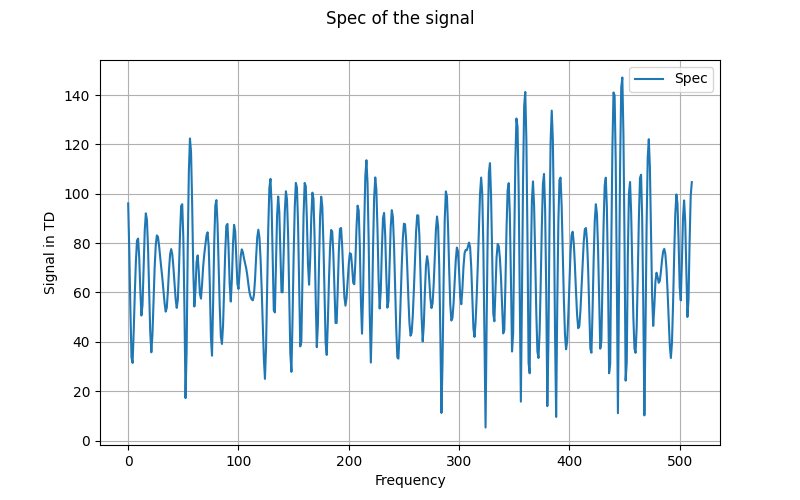

In [52]:
N = 512

fig2_1 = plt.figure(figsize=(8,5))
ax_1 = fig2_1.add_subplot(111)
ax_1.plot(np.arange(0, N, 1), np.abs(fft((info_frame_td['Re']+1j*info_frame_td['Im']).to_numpy(), N)), label='Spec')
ax_1.set_ylabel("Signal in TD")
ax_1.set_xlabel(r"Frequency")
ax_1.legend()
ax_1.grid()
#ax_1.set_title('Real part')
fig2_1.suptitle('Spec of the signal')
plt.show()

### Пилотный сигнал и его спектр

In [53]:
pilots_frame = pd.read_csv('model_290324_CP_ber_evm\\pilots_frame.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
pilots_frame_td = pd.read_csv('model_290324_CP_ber_evm\\pilots_frame_td.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])

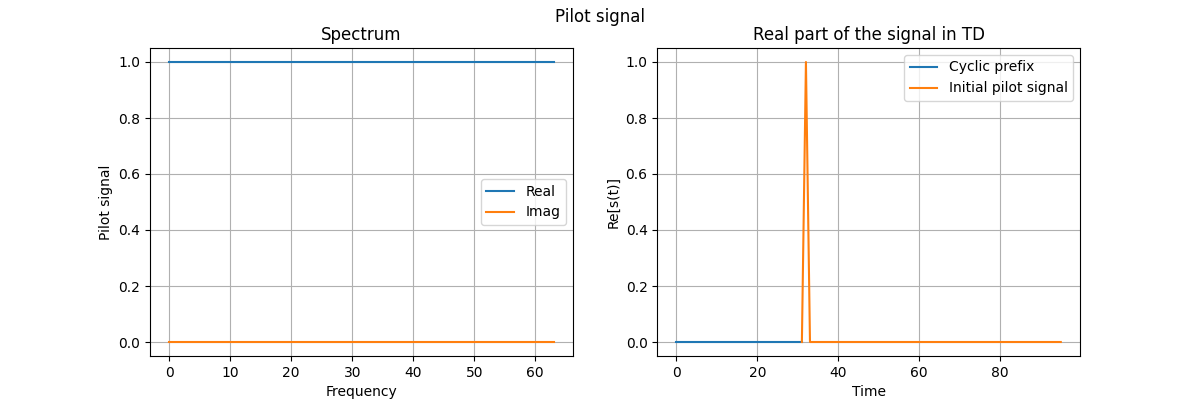

In [54]:
fig3 = plt.figure(figsize=(12,4))
ax_1 = fig3.add_subplot(121)
ax_1.plot(pilots_frame.index, pilots_frame['Re'], label='Real')
ax_1.plot(pilots_frame.index, pilots_frame['Im'], label='Imag')
ax_1.set_ylabel("Pilot signal")
ax_1.set_xlabel(r"Frequency")
ax_1.legend()
ax_1.grid()
ax_1.set_title('Spectrum')
fig3.suptitle('Pilot signal')

ax_2 = fig3.add_subplot(122)
ax_2.plot(pilots_frame_td.index[:cp_size], pilots_frame_td['Re'][:cp_size], label='Cyclic prefix')
ax_2.plot(pilots_frame_td.index[cp_size-1:], pilots_frame_td['Re'][cp_size-1:], label='Initial pilot signal')
ax_2.set_ylabel("Re[s(t)]")
ax_2.set_xlabel(r"Time")
ax_2.legend()
ax_2.grid()
ax_2.set_title('Real part of the signal in TD')
plt.show()

### Зависимость EVM и Uncoded BER от SNR

In [55]:
psk2 = pd.read_csv("model_plot_characteristics\\metricsM2.txt", header=0, skipinitialspace=True, index_col=False)
psk4 = pd.read_csv("model_plot_characteristics\\metricsM4.txt", header=0, skipinitialspace=True, index_col=False)
psk8 = pd.read_csv("model_plot_characteristics\\metricsM8.txt", header=0, skipinitialspace=True, index_col=False)
qam16 = pd.read_csv("model_plot_characteristics\\metricsM16.txt", header=0, skipinitialspace=True, index_col=False)
qam64 = pd.read_csv("model_plot_characteristics\\metricsM64.txt", header=0, skipinitialspace=True, index_col=False)

bertool = pd.read_csv("model_plot_characteristics\\bertool_res.txt", header=0, skipinitialspace=True, index_col=False)

Text(0.5, 1.0, 'Uncoded BER')

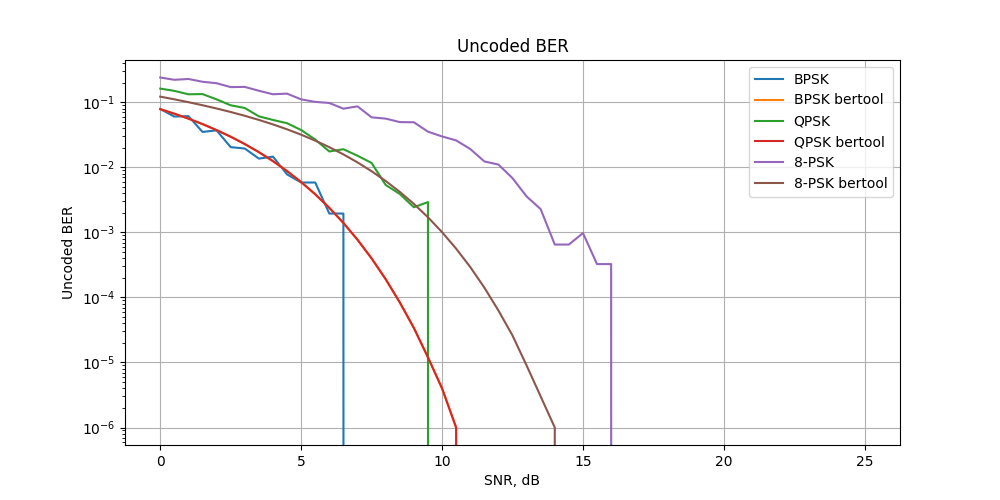

In [56]:
fig4 = plt.figure(figsize=(10,5))
ax_1 = fig4.add_subplot(111)
ax_1.plot(psk2['SNR_dB'], psk2['BER_my'], label='BPSK')
ax_1.plot(bertool['SNR'], bertool['bpsk'], label='BPSK bertool')
ax_1.plot(psk4['SNR_dB'], psk4['BER_my'], label='QPSK')
ax_1.plot(bertool['SNR'], bertool['qpsk'], label='QPSK bertool')
ax_1.plot(psk8['SNR_dB'], psk8['BER_my'], label='8-PSK')
ax_1.plot(bertool['SNR'], bertool['8psk'], label='8-PSK bertool')
# ax_1.plot(qam16['SNR_dB'], qam16['BER_my'], label='QAM-16')
# ax_1.plot(qam64['SNR_dB'], qam64['BER_my'], label='QAM-64')

ax_1.set_ylabel("Uncoded BER")
ax_1.set_xlabel(r"SNR, dB")
ax_1.set_yscale('log')
ax_1.legend()
ax_1.grid()
ax_1.set_title('Uncoded BER')

Text(0.5, 1.0, 'EVM')

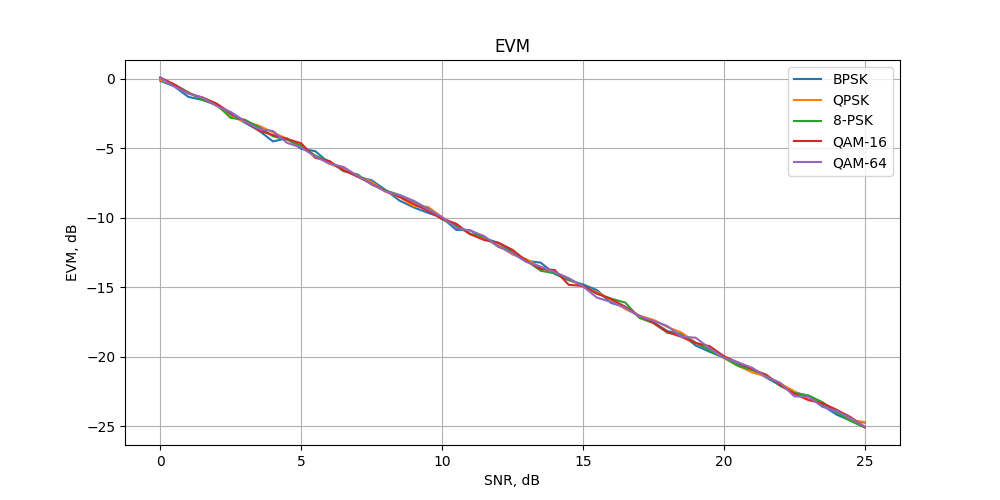

In [57]:
fig4 = plt.figure(figsize=(10,5))
ax_1 = fig4.add_subplot(111)
ax_1.plot(psk2['SNR_dB'], 20*np.log10(psk2['EVM_my']), label='BPSK')
ax_1.plot(psk4['SNR_dB'], 20*np.log10(psk4['EVM_my']), label='QPSK')
ax_1.plot(psk8['SNR_dB'], 20*np.log10(psk8['EVM_my']), label='8-PSK')
ax_1.plot(qam16['SNR_dB'], 20*np.log10(qam16['EVM_my']), label='QAM-16')
ax_1.plot(qam64['SNR_dB'], 20*np.log10(qam64['EVM_my']), label='QAM-64')
ax_1.set_ylabel("EVM, dB")
ax_1.set_xlabel(r"SNR, dB")
ax_1.legend()
ax_1.grid()
ax_1.set_title('EVM')